In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score


# TIME-BASED SPLITTING


In [2]:
import random
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)
final = final.sort_values(by=['Time'],ascending=False)
finalDataPoints = final.head(8000)
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']

In [3]:
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x_tr,y_tr,test_size=0.2,shuffle=False)

# Word2Vec

In [4]:
i = 0
list_of_sent = []
for sent in x_train:
    list_of_sent.append(sent.split())

i = 0
list_of_sent_cv = []
for sent in x_cv:
    list_of_sent_cv.append(sent.split())
    
i = 0
list_of_sent_test = []
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [5]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size=50)

In [6]:
w2v_words = list(w2v_model.wv.vocab)
print('Number of words that occured minumum 5 times', len(w2v_words))
print('sample of words',w2v_words[0:50])

Number of words that occured minumum 5 times 2904
sample of words ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'top', 'done', 'research', 'also', 'found', 'toxic', 'pet']


# Avg-W2V

In [8]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5120
50


In [13]:
# avg_w2v for cv data
sent_vectors_cv = []

for sent in list_of_sent_cv:
    
    sent_vec = np.zeros(50)
    cnt_words = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    
    sent_vectors_cv.append(sent_vec)

print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
            
            

1280
50


In [14]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words+=1
        
    if cnt_words != 0:
        sent_vec /= cnt_words
    
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

1600
50


In [16]:
x_test = sent_vectors_test
x_cv = sent_vectors_cv
x_train = sent_vectors

scores = []

myList = list(range(0,30))
neighbors = list(filter(lambda x: x%2 != 0,myList))
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i,algorithm='brute')
    knn.fit(x_train,y_train)
    pred = knn.predict(x_cv)
    score = f1_score(y_cv,pred,average='micro')
    scores.append(score)
optimal_k_using_avgw2v = neighbors[scores.index(max(scores))]
print('\nThe optimal number of neighbors is =>',optimal_k_using_avgw2v)


The optimal number of neighbors is => 17


Accuracy on test set: 83.4375
Precision on test set: 0.6686633039092056
Recall on test set: 0.5105858243233694
F1-score on test set:  0.47972842805588994
Confusion matrix of test set:
[[TN FP]
 [FN TP]]



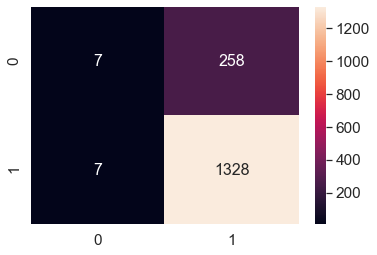

In [18]:
knn = KNeighborsClassifier(optimal_k_using_avgw2v)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print("Accuracy on test set:",(accuracy_score(y_test,y_pred)*100))
print("Precision on test set:",(precision_score(y_test,y_pred,average='macro')))
print("Recall on test set:",recall_score(y_test,y_pred,average='macro'))
print("F1-score on test set: ",f1_score(y_test,y_pred,average='macro'))
print('Confusion matrix of test set:\n[[TN FP]\n [FN TP]]\n')
#
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')


In [ ]:
#bag of words
# 1.Unigram
bow = CountVectorizer()
x_train = bow.fit_transform(x_train)
x_test = bow.transform(x_test)
x_cv = bow.transform(x_cv)


In [ ]:
# Finding optimal K
myList = list(range(0,30))
neighbors = list(filter(lambda x: x%2 != 0,myList))
print('List of neighbors:',neighbors)
print('=>'*50)
scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm = 'brute')
    
    # fitting the model on crossvalidation train
    knn.fit(x_train,y_train)
    
    pred = knn.predict(x_cv)
    
    score = f1_score(y_cv,pred,average='micro')
    print('Score on {} neighbors => '.format(i),score)
    scores.append(score)

MSE = [1-x for x in scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\n The optimal number of neighbors is',optimal_k)    

## ploting confusion matrix and finding f1_score given optimal value of k

In [ ]:
knn = KNeighborsClassifier(optimal_k)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print("Accuracy on test set:",(accuracy_score(y_test,y_pred)*100))
print("Precision on test set:",(precision_score(y_test,y_pred,average='macro')))
print("Recall on test set:",recall_score(y_test,y_pred,average='macro'))
print("F1-score on test set: ",f1_score(y_test,y_pred,average='macro'))
print('Confusion matrix of test set:\n[[TN FP]\n [FN TP]]\n')
#
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')


# TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_cv = tf_idf_vect.transform(x_cv)

myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0,myList))
scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(x_train,y_train)
    pred = knn.predict(x_cv)
    score = f1_score(y_cv,pred,average='micro')
    scores.append(score)

MSE = [1 - x for x in scores]
optimal_k_using_tfidf = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is',optimal_k_using_tfidf)

In [ ]:
knn = KNeighborsClassifier(optimal_k_using_tfidf)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print("Accuracy on test set:",(accuracy_score(y_test,y_pred)*100))
print("Precision on test set:",(precision_score(y_test,y_pred,average='macro')))
print("Recall on test set:",recall_score(y_test,y_pred,average='macro'))
print("F1-score on test set: ",f1_score(y_test,y_pred,average='macro'))
print('Confusion matrix of test set:\n[[TN FP]\n [FN TP]]\n')
#
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')


# TFIDF-W2V

In [20]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)
final = final.sort_values(by=['Time'],ascending=False)
finalDataPoints = final.head(8000)
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x_tr,y_tr,test_size=0.2,shuffle=False)
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))

In [23]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row = 0
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row+=1

100%|█████████████████████████████████████████████████████████████████████████████| 5120/5120 [00:05<00:00, 854.23it/s]


In [24]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []
row = 0
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1    

100%|█████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:02<00:00, 752.44it/s]


In [25]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_cv = []
row = 0
for sent in tqdm(list_of_sent_cv):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row+=1    

100%|█████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:01<00:00, 816.43it/s]


In [29]:
x_test = tfidf_sent_vectors_test
x_cv = tfidf_sent_vectors_cv
x_train = tfidf_sent_vectors
scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x%2 != 0, myList))
for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(x_train,y_train)
    pred = knn.predict(tfidf_sent_vectors_cv)
    score = f1_score(y_cv,pred,average='micro')
    scores.append(score)
optimal_k_using_tfidf_w2v = neighbors[scores.index(max(scores))]
print(optimal_k_using_tfidf_w2v)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.43it/s]

29


Accuracy on test set: 83.125
Precision on test set: 0.4885660478880818
Recall on test set: 0.49963960144159425
F1-score on test set:  0.4575699132111861
Confusion matrix of test set:
[[TN FP]
 [FN TP]]



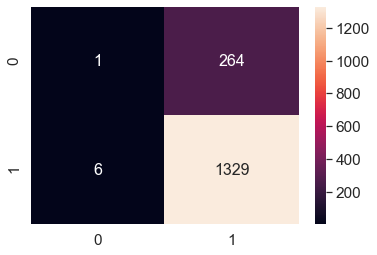

In [30]:
knn = KNeighborsClassifier(optimal_k_using_tfidf_w2v)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print("Accuracy on test set:",(accuracy_score(y_test,y_pred)*100))
print("Precision on test set:",(precision_score(y_test,y_pred,average='macro')))
print("Recall on test set:",recall_score(y_test,y_pred,average='macro'))
print("F1-score on test set: ",f1_score(y_test,y_pred,average='macro'))
print('Confusion matrix of test set:\n[[TN FP]\n [FN TP]]\n')
#
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
